### Working on Correlation Stuff

In [88]:
# UST HRV and Normal HRV Correlation Analysis for Stress Detection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Important Note
This notebook performs correlation analysis between ground truth physiological signals and remote photoplethysmography (rPPG) signals from the UBFC-Phys dataset. It implements proper signal processing to convert BVP/PPG signals to RR intervals and calculates various HRV metrics including the Baevsky Stress Index.

In [89]:
# Custom function for Bland-Altman plots
def bland_altman_plot(data1, data2, title, ylabel='Difference', xlabel='Mean'):
    """
    Creates a Bland-Altman plot to compare two measurement methods
    """
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(mean, diff, alpha=0.7)
    plt.axhline(md, color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='r', linestyle='--')
    plt.axhline(md - 1.96*sd, color='r', linestyle='--')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.annotate(f'Mean diff: {md:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
    plt.annotate(f'95% limits: [{md - 1.96*sd:.2f}, {md + 1.96*sd:.2f}]', xy=(0.05, 0.85), xycoords='axes fraction')
    plt.grid(True, alpha=0.3)
    return plt



In [90]:
# Function to compute Baevsky Stress Index
def compute_bsi(rr_intervals):
    """
    Computes Baevsky Stress Index from RR intervals
    BSI = AMo / (2 * Mo * MxDMn)
    where:
    - AMo is the amplitude of the mode (% of RR intervals falling within mode bin)
    - Mo is the mode value (most common RR interval value)
    - MxDMn is the variation scope (difference between max and min RR intervals)
    """
    # Ensure there are enough intervals toa calculate BSI
    if len(rr_intervals) < 10:
        return np.nan
        
    # Calculate mode (Mo) - the most common RR interval value
    hist, bin_edges = np.histogram(rr_intervals, bins="fd")
    bin_idx = np.argmax(hist)
    Mo = (bin_edges[bin_idx] + bin_edges[bin_idx + 1]) / 2
    
    # Calculate AMo (amplitude of mode) - percentage of intervals corresponding to mode value
    # Using the stricter definition: percentage in the modal bin only
    AMo = 100 * hist[bin_idx] / len(rr_intervals)
    
    # Calculate MxDMn (variation range) - difference between max and min RR intervals
    MxDMn = np.max(rr_intervals) - np.min(rr_intervals)
    
    # Calculate Stress Index using revised Baevsky's formula with scaling factor
    stress_index = (AMo / 100) / (2 * Mo / 1000 * MxDMn / 1000) * 1000
    # This simplifies to: stress_index = AMo * 1000 / (2 * Mo * MxDMn / 1000)
    
    return stress_index


In [91]:
# def compute_bsi(rr_intervals):
#     """
#     Computes Baevsky Stress Index from RR intervals
#     BSI = AMo / (2 * Mo * MxDMn)
#     where:
#     - AMo is the amplitude of the mode (% of RR intervals falling within mode bin)
#     - Mo is the mode value (most common RR interval value)
#     - MxDMn is the variation scope (difference between max and min RR intervals)
#     """
#     # Ensure there are enough intervals to calculate BSI
#     if len(rr_intervals) < 10:
#         return np.nan
        
#     # Calculate mode value (Mo)
#     hist, bin_edges = np.histogram(rr_intervals, bins=16)
#     bin_idx = np.argmax(hist)
#     mo = (bin_edges[bin_idx] + bin_edges[bin_idx + 1]) / 2
    
#     # Calculate amplitude of mode (AMo) - percentage of intervals in mode bin
#     amo = hist[bin_idx] / len(rr_intervals) * 100
    
#     # Calculate variation scope (MxDMn)
#     mxdmn = np.max(rr_intervals) - np.min(rr_intervals)
    
#     # Avoid division by zero
#     if mo * mxdmn == 0:
#         return np.nan
        
#     # Calculate Baevsky Stress Index
#     bsi = amo / (2 * mo * mxdmn)
    
#     return bsi


In [92]:
# Function to calculate time-domain HRV features
def compute_hrv_features(rr_intervals):
    """
    Computes common time-domain HRV features from RR intervals
    """
    if len(rr_intervals) < 10:
        return {
            'meanNN': np.nan,
            'SDNN': np.nan,
            'meanHR': np.nan,
            'RMSSD': np.nan,
            'pNN50': np.nan,
            'BSI': np.nan
        }
        
    # Mean NN (RR) intervals in ms
    meanNN = np.mean(rr_intervals)
    
    # Standard deviation of NN intervals
    sdnn = np.std(rr_intervals)
    
    # Mean heart rate (bpm)
    mean_hr = 60000 / meanNN
    
    # RMSSD - Root Mean Square of Successive Differences
    diff_rr = np.diff(rr_intervals)
    rmssd = np.sqrt(np.mean(diff_rr**2))
    
    # pNN50 - Percentage of successive NN intervals differing by more than 50ms
    nn50 = sum(abs(diff_rr) > 50)
    pnn50 = (nn50 / len(diff_rr)) * 100 if len(diff_rr) > 0 else 0
    
    # Baevsky Stress Index
    bsi = compute_bsi(rr_intervals)
    
    return {
        'meanNN': meanNN,
        'SDNN': sdnn,
        'meanHR': mean_hr,
        'RMSSD': rmssd,
        'pNN50': pnn50,
        'BSI': bsi
    }


In [93]:
def convert_bvp_to_rr(bvp_signal, sampling_rate=64, visualize=False, task="T1", subject="S1"):
    """
    Converts a BVP/PPG signal to RR intervals using peak detection
    
    Parameters:
    -----------
    bvp_signal : numpy.ndarray
        The raw BVP/PPG signal
    sampling_rate : int
        Sampling rate of the signal in Hz (default: 64)
    visualize : bool
        Whether to visualize the peak detection (default: False)
        
    Returns:
    --------
    rr_intervals : numpy.ndarray
        Array of RR intervals in milliseconds
    """
    from scipy.signal import butter, filtfilt, find_peaks, resample
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Step 0: Upsample the signal to 200Hz
    target_rate = 200
    upsample_factor = target_rate / sampling_rate
    # Calculate the new length after upsampling
    new_length = int(len(bvp_signal) * upsample_factor)
    # Resample the signal
    upsampled_bvp = resample(bvp_signal, new_length)
    
    # Update sampling rate to reflect the upsampled signal
    upsampled_rate = target_rate
    
    # Step 1: Apply bandpass filter (0.5-8 Hz for heart rate range)
    nyquist = 0.5 * upsampled_rate
    low = 0.5 / nyquist
    high = 3 / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered_bvp = filtfilt(b, a, upsampled_bvp)
    
    # Step 2: Find peaks in the filtered signal
    # Adjust distance parameter to account for higher sampling rate
    peaks, _ = find_peaks(filtered_bvp, distance=upsampled_rate//2, height=0.2*np.std(filtered_bvp))
    
    # Step 3: Calculate RR intervals in milliseconds
    peak_times = peaks / upsampled_rate * 1000  # Convert to ms
    rr_intervals = np.diff(peak_times)
    
    # Step 4: Basic quality control - remove physiologically implausible intervals
    valid_mask = (rr_intervals > 300) & (rr_intervals < 2000)  # 30-200 bpm range
    rr_intervals = rr_intervals[valid_mask]
    
    # Optional visualization
    if visualize and len(peaks) > 1:
        plt.figure(figsize=(15, 6))
        
        # Plot original and upsampled signals
        time_axis_orig = np.arange(len(bvp_signal)) / sampling_rate
        time_axis_up = np.arange(len(upsampled_bvp)) / upsampled_rate
        
        plt.subplot(3, 1, 1)
        plt.plot(time_axis_orig, bvp_signal, 'b-', label='Original Signal')
        plt.title(f'Original BVP Signal ({sampling_rate}Hz) - Task: {task}, Subject: {subject}')
        plt.legend()
        
        # Plot upsampled and filtered signal
        plt.subplot(3, 1, 2)
        plt.plot(time_axis_up, upsampled_bvp, 'r-', alpha=0.5, label=f'Upsampled ({upsampled_rate}Hz)')
        plt.plot(time_axis_up, filtered_bvp, 'g-', label='Filtered')
        plt.plot(peaks/upsampled_rate, filtered_bvp[peaks], 'ko', label='Peaks')
        plt.title('Upsampled BVP Signal with Detected Peaks')
        plt.legend()
        
        # Plot RR intervals
        plt.subplot(3, 1, 3)
        plt.plot(rr_intervals, 'b-')
        plt.title('RR Intervals')
        plt.ylabel('Time (ms)')
        plt.xlabel('Beat number')
        plt.tight_layout()
        plt.show()
    
    return rr_intervals

In [94]:
# Function to segment data
def segment_data(data, segment_length, total_length=180):
    """
    Segments data into specified lengths
    segment_length in seconds, assuming data is sampled by RR intervals
    total_length is the total recording length in seconds
    """
    # Convert RR intervals to cumulative time
    time_points = np.cumsum(data) / 1000  # convert from ms to seconds
    
    # Create segments
    segments = {}
    
    if segment_length == 30:
        # 30s segment - take first 30 seconds
        mask = time_points <= 30
        segments['30s'] = data[mask] if any(mask) else np.array([])
    
    elif segment_length == 60:
        # 1min segment - take first minute
        mask = time_points <= 60
        segments['1min'] = data[mask] if any(mask) else np.array([])
    
    elif segment_length == 120:
        # 2min segment - take first two minutes
        mask = time_points <= 120
        segments['2min'] = data[mask] if any(mask) else np.array([])
    
    elif segment_length == total_length:
        # Full recording - all data
        segments['full'] = data
        
    return segments


In [95]:
# Function to calculate sliding window BSI values
def sliding_window_bsi(rr_intervals, window_size, step_size=5):
    """
    Calculates BSI using sliding windows across the data
    window_size: Size of window in seconds
    step_size: Step size in seconds for sliding the window
    """
    # Convert RR intervals to cumulative time
    cum_time = np.cumsum(rr_intervals) / 1000  # convert ms to seconds
    total_time = cum_time[-1]
    
    bsi_values = []
    window_centers = []
    
    current_pos = 0
    while current_pos + window_size <= total_time:
        window_end = current_pos + window_size
        
        # Find RR intervals within this window
        window_indices = (cum_time > current_pos) & (cum_time <= window_end)
        
        # Make sure we include the RR interval that starts before the window
        if current_pos > 0:
            # Find the last RR interval that started before the window
            last_before = np.where(cum_time <= current_pos)[0][-1]
            window_indices[last_before] = True
            
        window_rr = rr_intervals[window_indices]
        
        # Calculate BSI for this window
        if len(window_rr) > 10:  # Ensure enough data points
            bsi = compute_bsi(window_rr)
            bsi_values.append(bsi)
            window_centers.append(current_pos + window_size/2)  # Center of the window
        
        # Slide window
        current_pos += step_size
    
    return np.array(window_centers), np.array(bsi_values)


### Main methods

Starting HRV correlation analysis for stress detection...
Loading data from UBFC-Phys dataset...


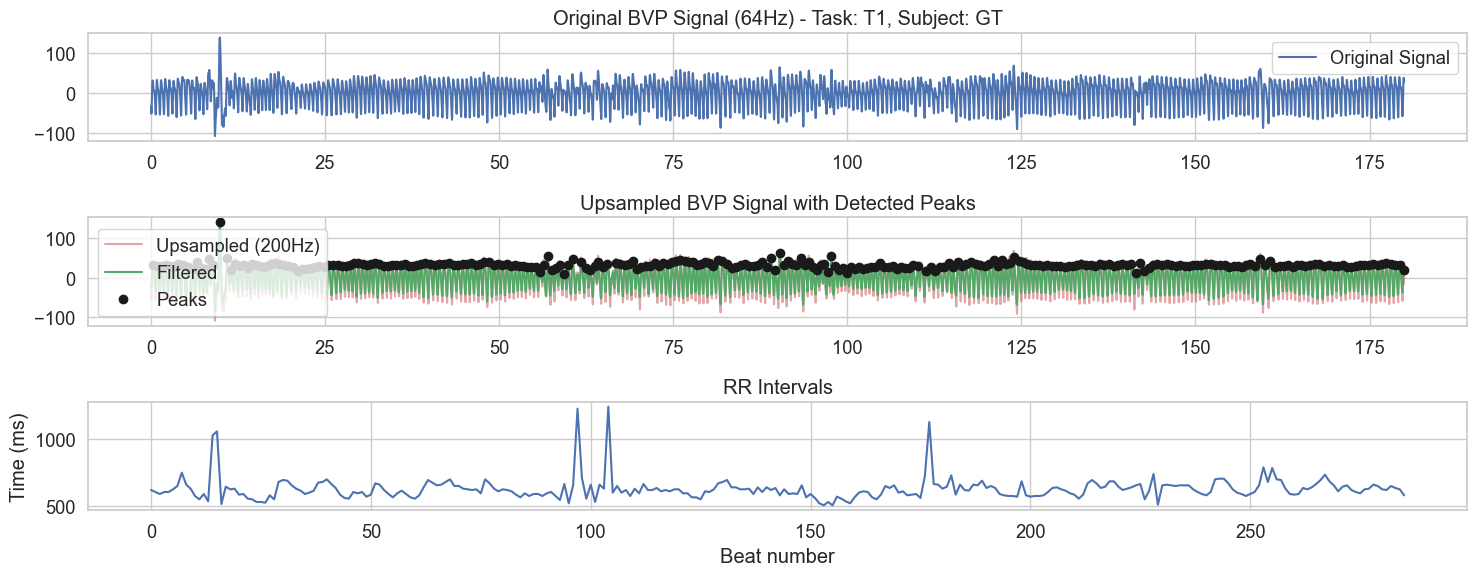

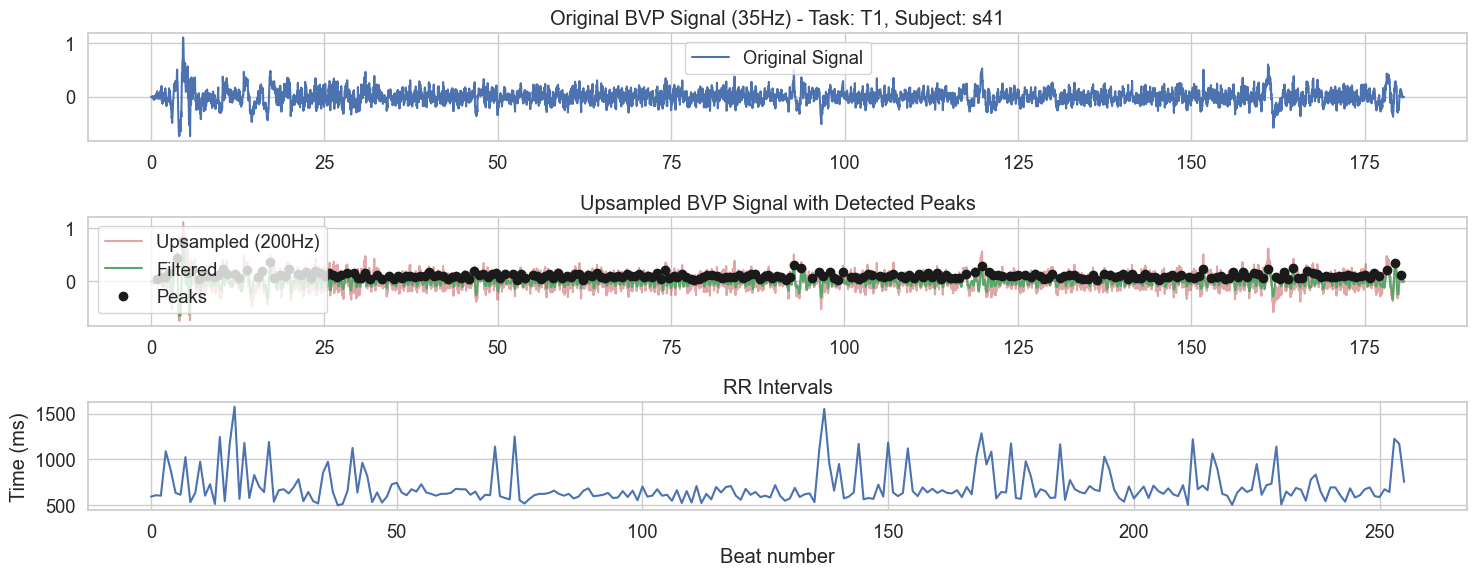

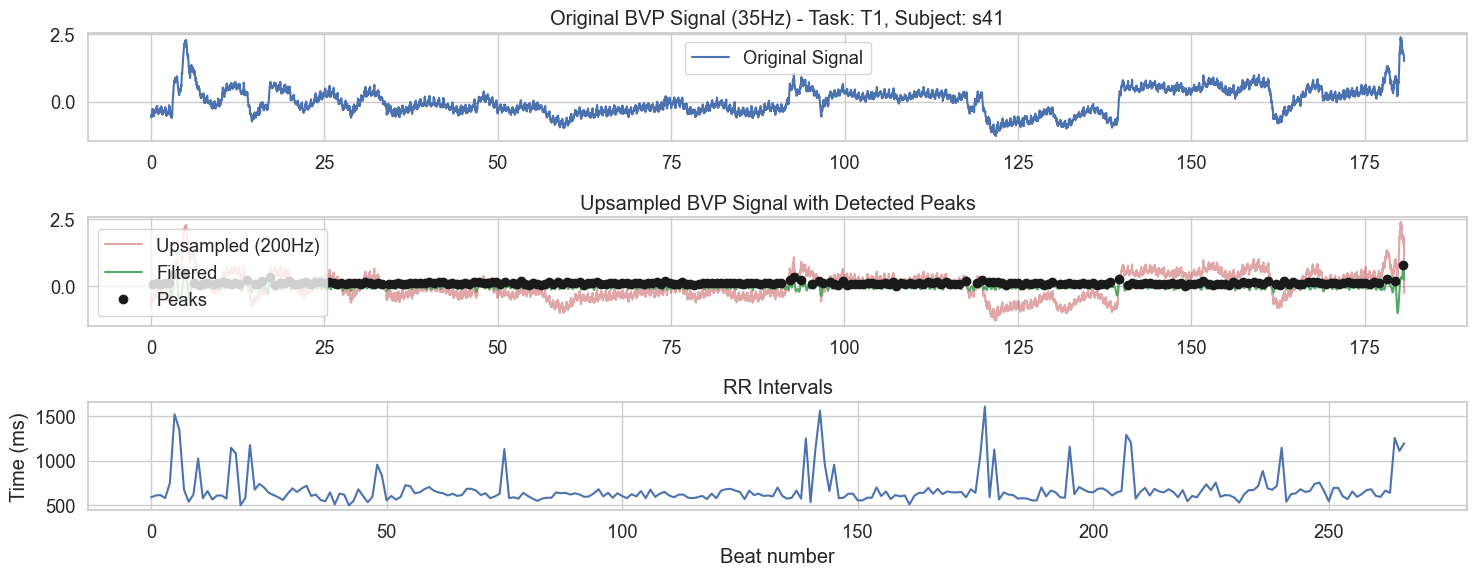

Loaded data for s41, task T1 - 286 GT and 256 rPPG RR intervals


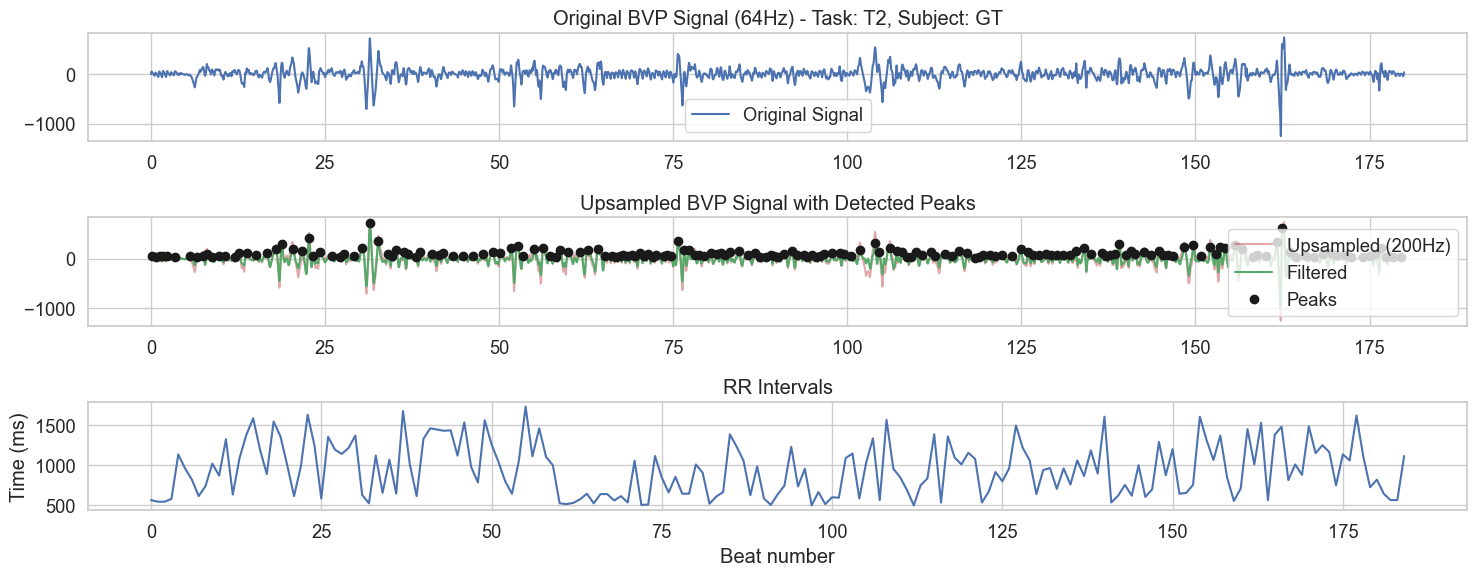

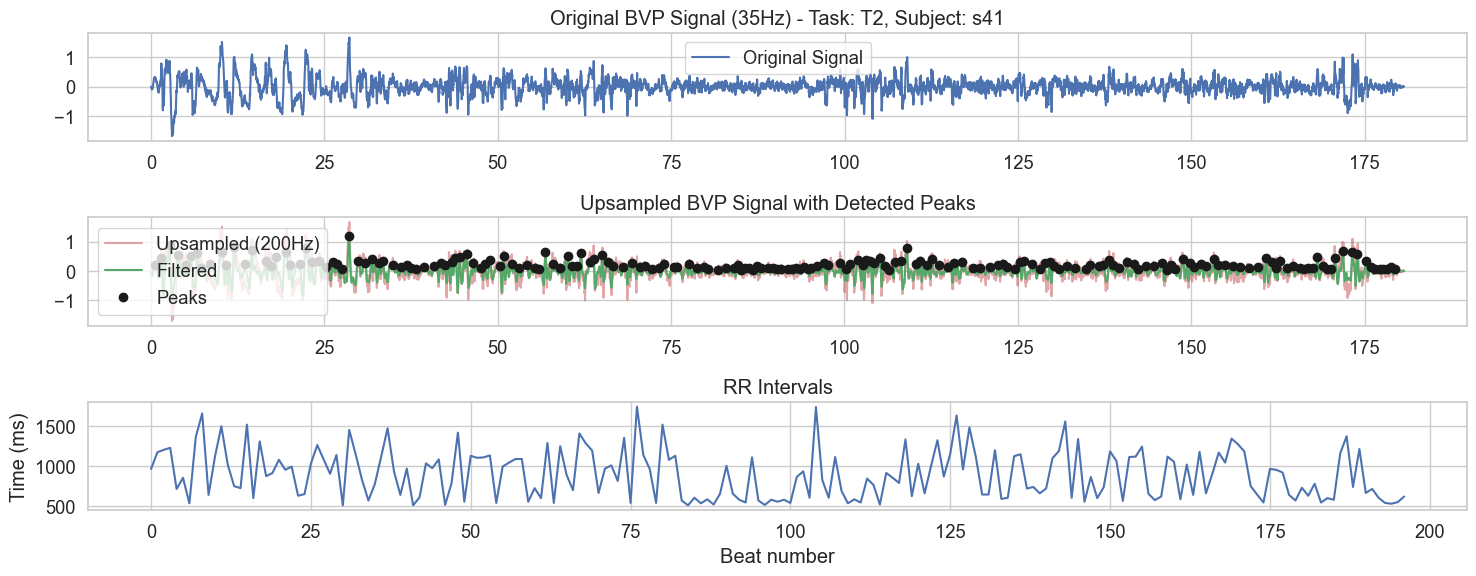

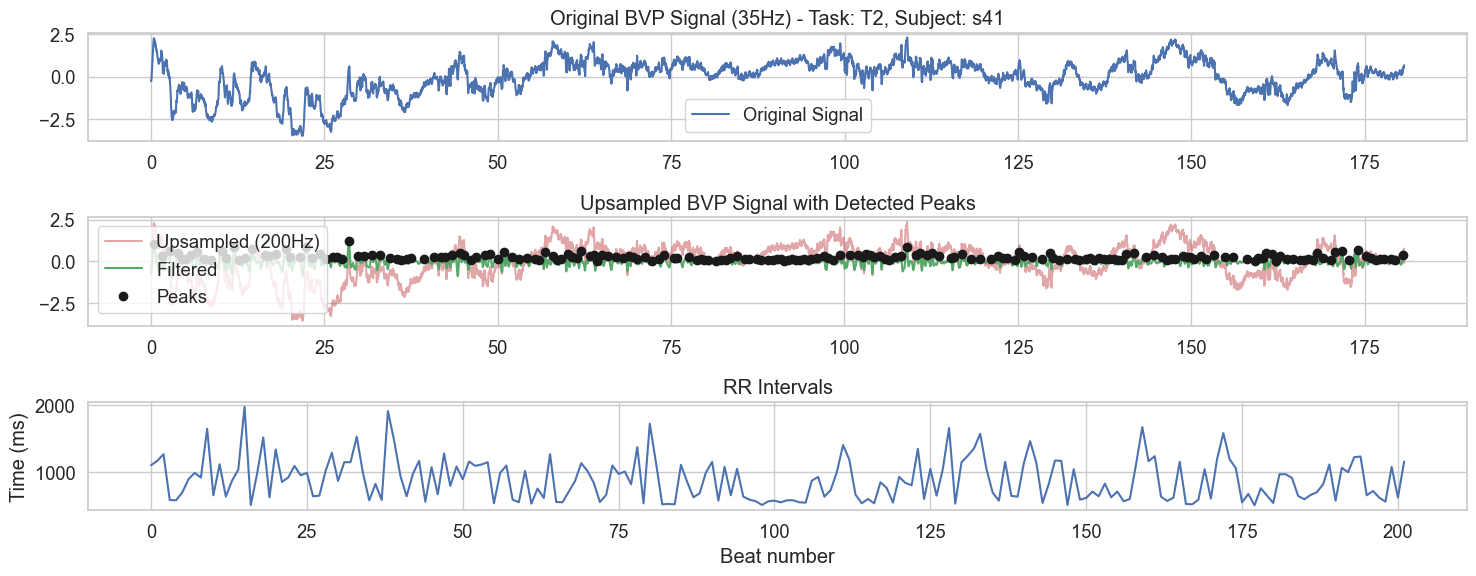

Loaded data for s41, task T2 - 185 GT and 197 rPPG RR intervals


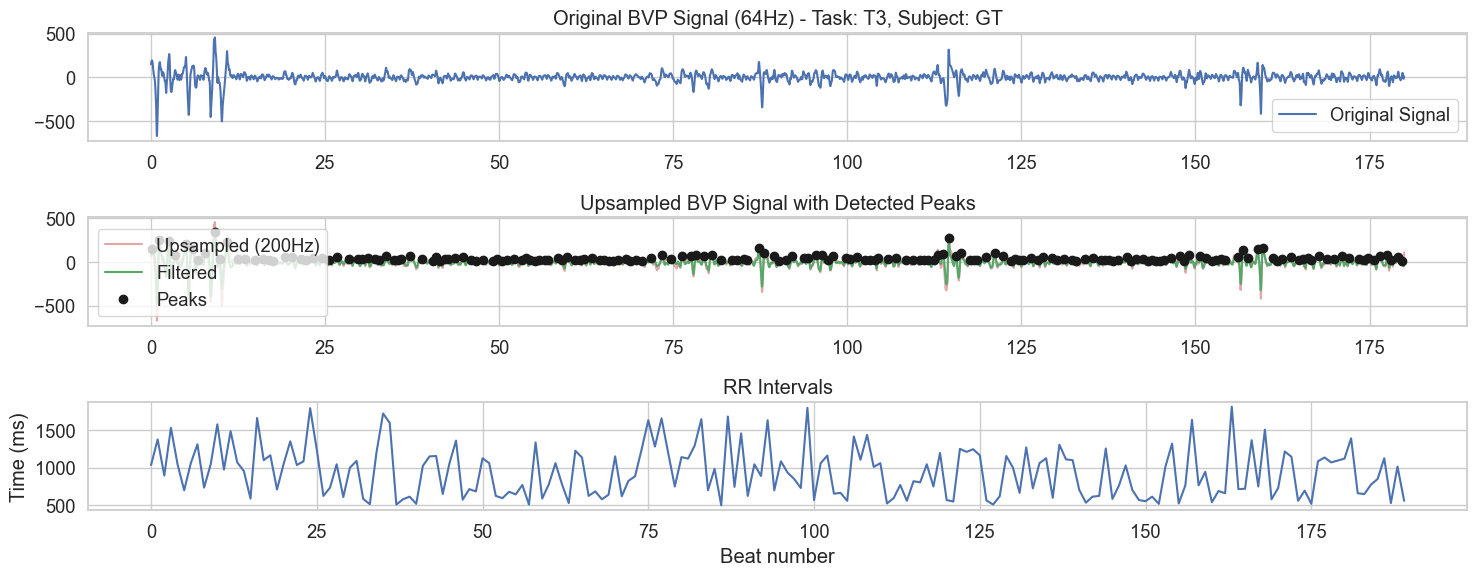

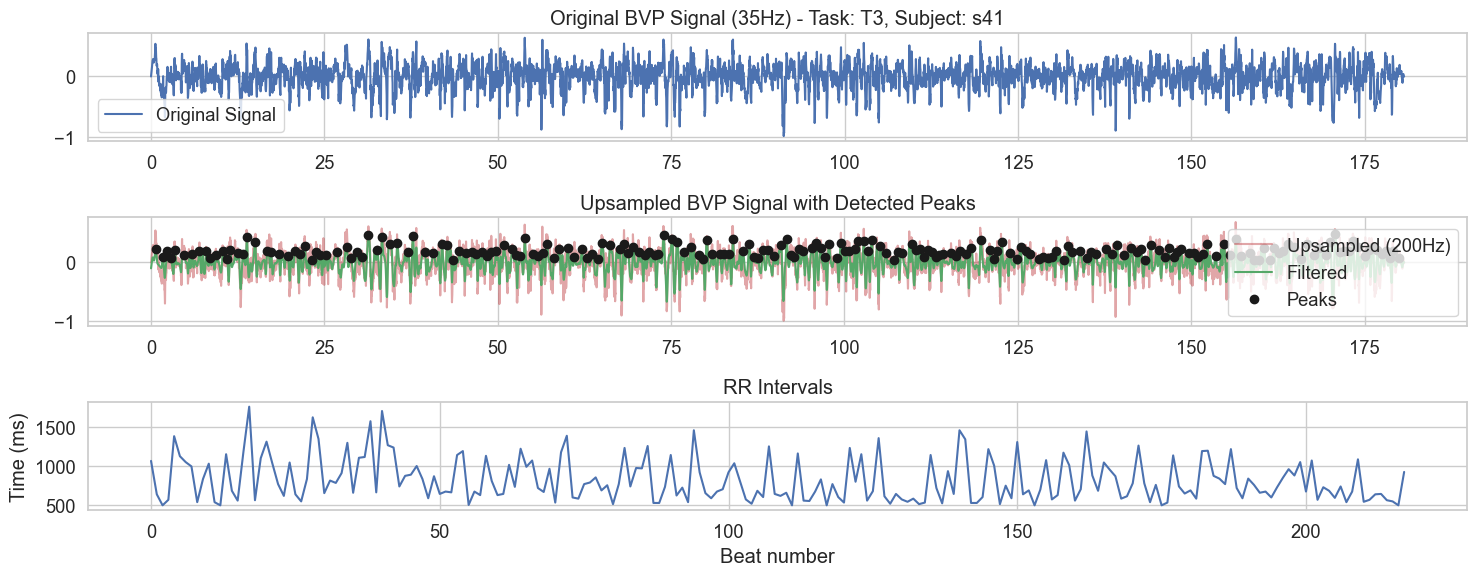

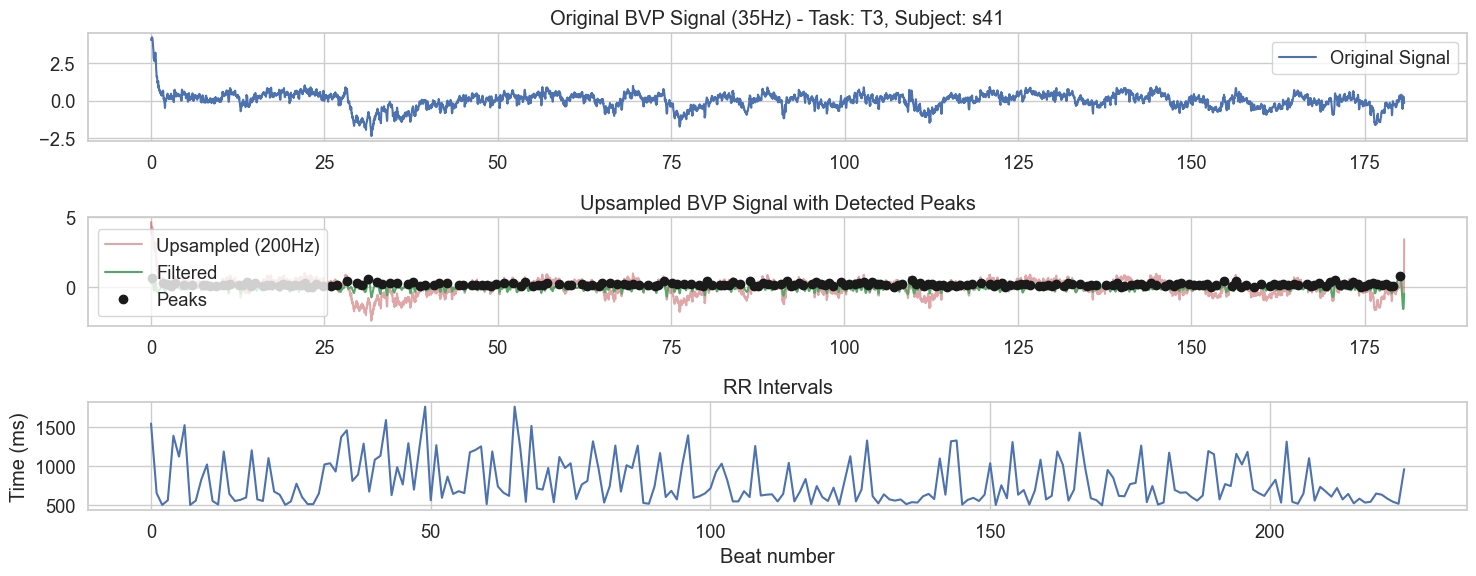

Loaded data for s41, task T3 - 190 GT and 218 rPPG RR intervals
Loaded data for s42, task T1 - 209 GT and 205 rPPG RR intervals
Loaded data for s42, task T2 - 194 GT and 183 rPPG RR intervals
Loaded data for s42, task T3 - 213 GT and 197 rPPG RR intervals
Loaded data for s43, task T1 - 281 GT and 253 rPPG RR intervals
Loaded data for s43, task T2 - 245 GT and 209 rPPG RR intervals
Loaded data for s43, task T3 - 226 GT and 198 rPPG RR intervals
Loaded data for s44, task T1 - 185 GT and 173 rPPG RR intervals
Loaded data for s44, task T2 - 179 GT and 184 rPPG RR intervals
Loaded data for s44, task T3 - 180 GT and 183 rPPG RR intervals
Loaded data for s45, task T1 - 225 GT and 213 rPPG RR intervals
Loaded data for s45, task T2 - 213 GT and 185 rPPG RR intervals
Loaded data for s45, task T3 - 237 GT and 188 rPPG RR intervals
Loaded data for s46, task T1 - 223 GT and 222 rPPG RR intervals
Loaded data for s46, task T2 - 202 GT and 197 rPPG RR intervals
Loaded data for s46, task T3 - 255 GT an

In [96]:
# Set random seed for reproducibility
np.random.seed(42)

print("Starting HRV correlation analysis for stress detection...")

# Step 1: Load Data from UBFC-Phys dataset
print("Loading data from UBFC-Phys dataset...")

root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56"]
tasks = ["T1", "T2","T3"]

# Store ground truth and rPPG data
gt_data = {}
rppg_data = {}

# Expected sampling rates (adjust if different for your dataset)
sample_rate_gt = 64  # Hz
sample_rate_video = 35 # Hz

# Counter for subject processing
processed_subjects = 0
visualize = True  # Set to True to visualize the peak detection process

# Process each subject and task
for subject in subjects:
    # Check if subject folder exists
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
        continue
    
    for task in tasks:
        # Generate a unique ID for each subject-task combination
        subject_task_id = f"{subject}_{task}"
        
        try:
            # Load rPPG signals from different methods
            pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
            lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
            omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
            green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
            chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

            # Load ground truth BVP
            GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
            GT = GT.flatten()
            
            # Extract RR intervals from ground truth and rPPG signals
            gt_rr = convert_bvp_to_rr(GT, sampling_rate=sample_rate_gt, visualize=visualize, task=task, subject="GT")
            
            # Use POS method as the primary rPPG signal
            # You could also implement a fusion approach or compare different methods
            pos_rr = convert_bvp_to_rr(pos, sampling_rate=sample_rate_video, visualize=visualize, task=task , subject=subject)
            lgi_rr = convert_bvp_to_rr(lgi, sampling_rate=sample_rate_video, visualize=visualize, task=task , subject=subject)
    
            # Store the data if we have enough valid RR intervals
            if len(gt_rr) >= 10 and len(pos_rr) >= 10:
                gt_data[subject_task_id] = gt_rr
                rppg_data[subject_task_id] = lgi_rr
                
                processed_subjects += 1
                print(f"Loaded data for {subject}, task {task} - {len(gt_rr)} GT and {len(pos_rr)} rPPG RR intervals")
            else:
                print(f"Not enough valid RR intervals for {subject}, task {task}")
            
        except FileNotFoundError as e:
            print(f"Could not load data for {subject}, task {task}: {e}")
        except Exception as e:
            print(f"Error processing {subject}, task {task}: {e}")
    
    ## Flag viz false
    visualize = False

print(f"\nSuccessfully processed {processed_subjects} subject-task combinations.")



Step 2: Analyzing correlation between GT data segments and full recordings...


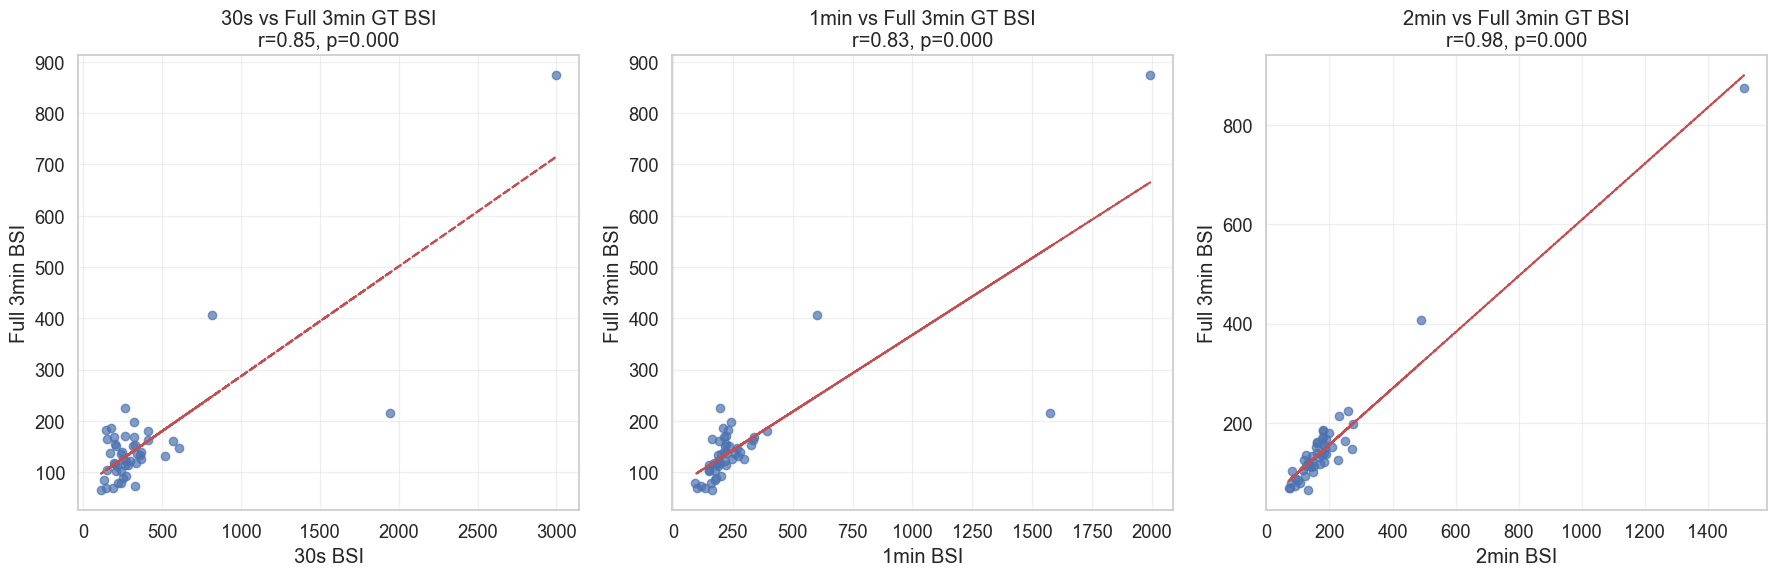

GT segment correlations with full 3min BSI:
  30s: r=0.85, p=0.000
  1min: r=0.83, p=0.000
  2min: r=0.98, p=0.000

Overall correlation quality assessment: Good


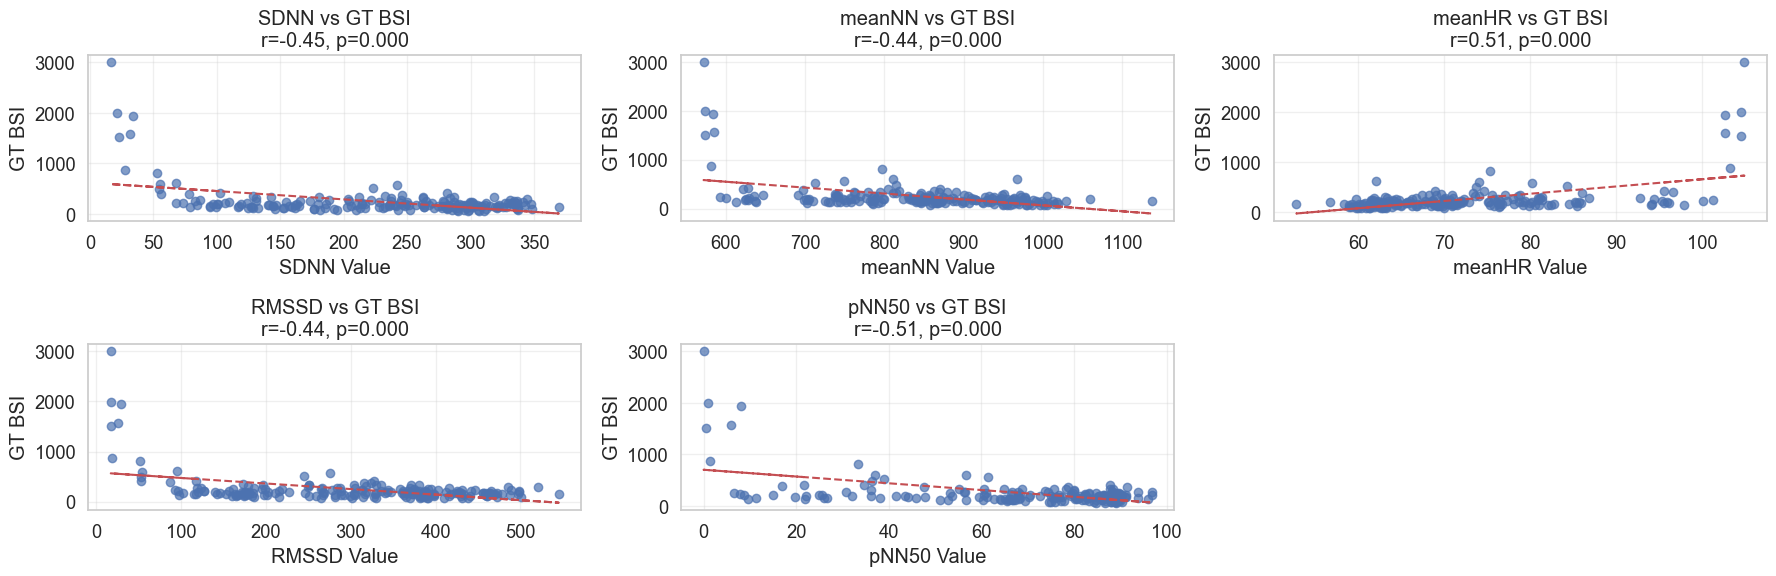

In [97]:
# Step 2: Initial Correlation Decision - Analyze GT data segments vs full recording
print("\nStep 2: Analyzing correlation between GT data segments and full recordings...")

# Prepare data structures to hold results
segment_lengths = [30, 60, 120, 180]  # seconds
segment_names = ['30s', '1min', '2min', 'full']

# Store BSI values for each subject and segment
gt_bsi_values = {segment: [] for segment in segment_names}

subject_ids = []

# Calculate BSI for different segments of GT data
for subject_id, rr_intervals in gt_data.items():
    subject_ids.append(subject_id)
    
    for i, segment_length in enumerate(segment_lengths):
        segments = segment_data(rr_intervals, segment_length)

        ## Sample debug data
        # print(segments)
    
        """
        These lines of code will takes the entire window (30 sec, 1 min and 2 min and compute the bsi and add them)
        That's why it has a lot of data points
        """
        for segment_name, segment_rr_data  in segments.items():
            if len(segment_rr_data ) > 0:
                bsi = compute_bsi(segment_rr_data)
                if segment_name in gt_bsi_values:
                    gt_bsi_values[segment_name].append(bsi)

# Convert to arrays for easier analysis
for segment in segment_names:
    gt_bsi_values[segment] = np.array(gt_bsi_values[segment])

# print(gt_bsi_values)

# Calculate correlation between each segment and full 3-min recording

"""
Adaptive filtering for the data points,  takes the gt_bsi_values that is consist of 3 time scenario and filter them based on the nan value
"""
correlations = {}
for segment in ['30s', '1min', '2min']:
    if len(gt_bsi_values[segment]) == len(gt_bsi_values['full']):
        mask = ~np.isnan(gt_bsi_values[segment]) & ~np.isnan(gt_bsi_values['full'])
        if sum(mask) > 3:  # Need at least a few valid points
            corr, p_value = stats.pearsonr(
                gt_bsi_values[segment][mask], 
                gt_bsi_values['full'][mask]
            )
            correlations[segment] = {
                'pearson_r': corr,
                'p_value': p_value
            }

# Plot correlations between GT segments and full recording
plt.figure(figsize=(18, 6))

for i, segment in enumerate(['30s', '1min', '2min']):
    plt.subplot(1, 3, i+1)
    
    if segment in correlations:
        valid_idx = ~np.isnan(gt_bsi_values[segment]) & ~np.isnan(gt_bsi_values['full'])
        plt.scatter(gt_bsi_values[segment][valid_idx], gt_bsi_values['full'][valid_idx], alpha=0.7)
        
        # Add best fit line
        x = gt_bsi_values[segment][valid_idx]
        y = gt_bsi_values['full'][valid_idx]
        if len(x) > 1:
            m, b = np.polyfit(x, y, 1)
            plt.plot(x, m*x + b, 'r--')
        
        plt.title(f"{segment} vs Full 3min GT BSI\nr={correlations[segment]['pearson_r']:.2f}, p={correlations[segment]['p_value']:.3f}")
    else:
        plt.title(f"{segment} vs Full 3min GT BSI\nInsufficient data")
        
    plt.xlabel(f"{segment} BSI")
    plt.ylabel("Full 3min BSI")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("gt_segment_correlations.png", dpi=300)
plt.show()

# Check if correlation is good (arbitrary threshold: r > 0.7 and p < 0.05)
good_correlation = all([
    segment in correlations and 
    correlations[segment]['pearson_r'] > 0.7 and 
    correlations[segment]['p_value'] < 0.05 
    for segment in ['30s', '1min', '2min']
])

print(f"GT segment correlations with full 3min BSI:")
for segment in ['30s', '1min', '2min']:
    if segment in correlations:
        print(f"  {segment}: r={correlations[segment]['pearson_r']:.2f}, p={correlations[segment]['p_value']:.3f}")
    else:
        print(f"  {segment}: Insufficient data")
        
print(f"\nOverall correlation quality assessment: {'Good' if good_correlation else 'Poor'}")

## Plot also the HRV time Features correlation with GT

# Extract time-domain features for each sliding window
time_features = {
    'SDNN': {'values': [], 'gt_bsi': []},
    'meanNN': {'values': [], 'gt_bsi': []},
    'meanHR': {'values': [], 'gt_bsi': []},
    'RMSSD': {'values': [], 'gt_bsi': []},
    'pNN50': {'values': [], 'gt_bsi': []}
}

## Compute the HRV Time Feature with the rr_intervals GT
for subject_id, rr_intervals in gt_data.items():
    for i, segment_length in enumerate(segment_lengths):
        segments = segment_data(rr_intervals, segment_length)
        
        for segment_name, segment_rr_data  in segments.items():
            if len(segment_rr_data ) > 0:
                features = compute_hrv_features(segment_rr_data)
                
                # Store the features
                for feature_name in time_features.keys():
                    time_features[feature_name]['values'].append(features[feature_name])
                    time_features[feature_name]['gt_bsi'].append(features['BSI'])

## Calculate correlation for each feature
feature_correlations = {}

for feature_name, data in time_features.items():
    if len(data['values']) == len(data['gt_bsi']):
        mask = ~np.isnan(data['values']) & ~np.isnan(data['gt_bsi'])
        if sum(mask) > 3:  # Need at least a few valid points
            corr, p_value = stats.pearsonr(
                np.array(data['values'])[mask], 
                np.array(data['gt_bsi'])[mask]
            )
            feature_correlations[feature_name] = {
                'pearson_r': corr,
                'p_value': p_value
            }

# Plot correlations for each feature
plt.figure(figsize=(18, 6))
for i, feature_name in enumerate(feature_correlations.keys()):
    plt.subplot(2, 3, i+1)
    
    valid_idx = ~np.isnan(time_features[feature_name]['values']) & ~np.isnan(time_features[feature_name]['gt_bsi'])
    plt.scatter(
        np.array(time_features[feature_name]['values'])[valid_idx], 
        np.array(time_features[feature_name]['gt_bsi'])[valid_idx], 
        alpha=0.7
    )
    
    # Add best fit line
    x = np.array(time_features[feature_name]['values'])[valid_idx]
    y = np.array(time_features[feature_name]['gt_bsi'])[valid_idx]
    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b, 'r--')
    
    plt.title(f"{feature_name} vs GT BSI\nr={feature_correlations[feature_name]['pearson_r']:.2f}, p={feature_correlations[feature_name]['p_value']:.3f}")
    plt.xlabel(f"{feature_name} Value")
    plt.ylabel("GT BSI")
    plt.grid(True, alpha=0.3)
plt.tight_layout()  


### Notes:

I'm soo cooked....


GT segments show good correlation with full recording. Proceeding with BSI analysis.


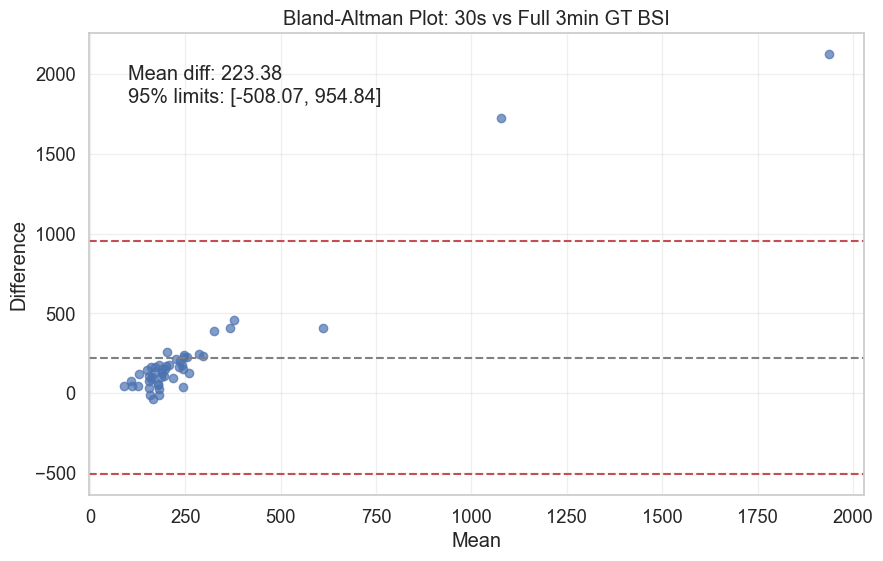

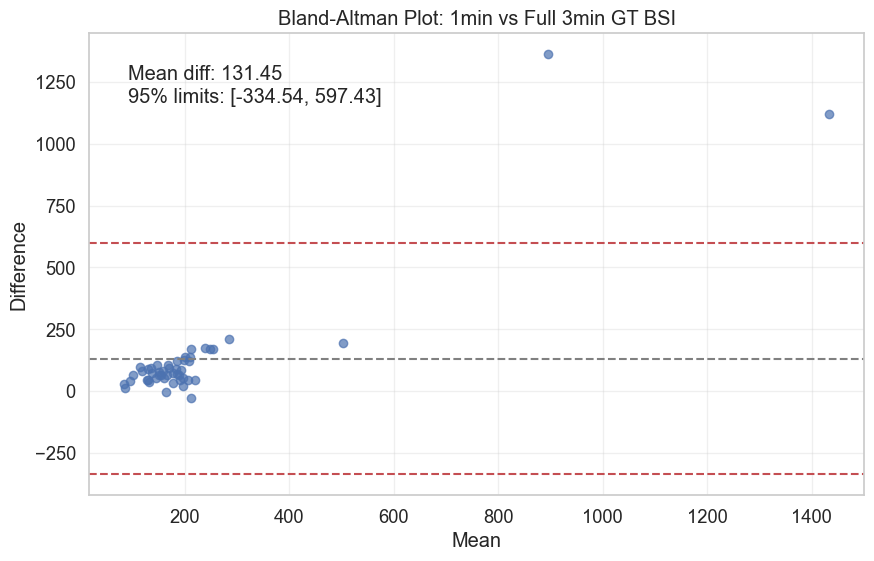

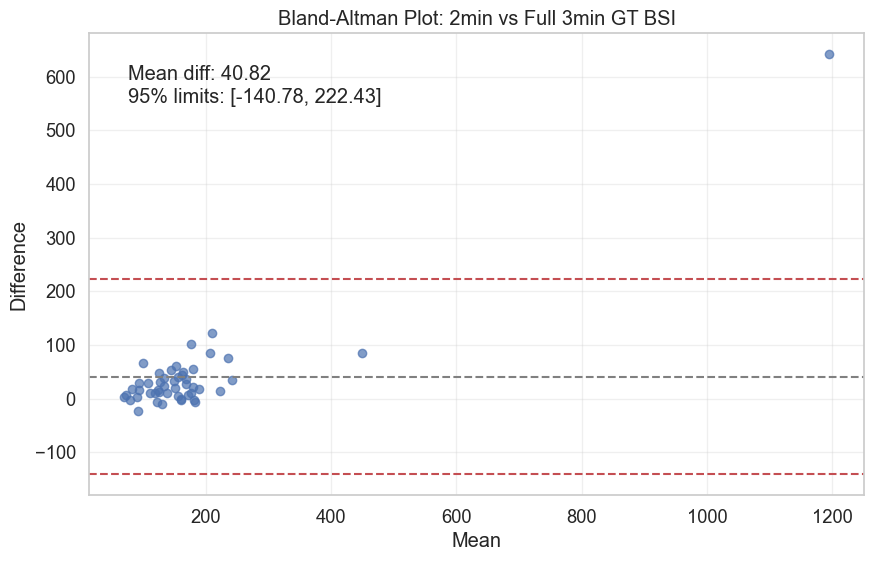


Step 3: Evaluating rPPG data correlation with ground truth...


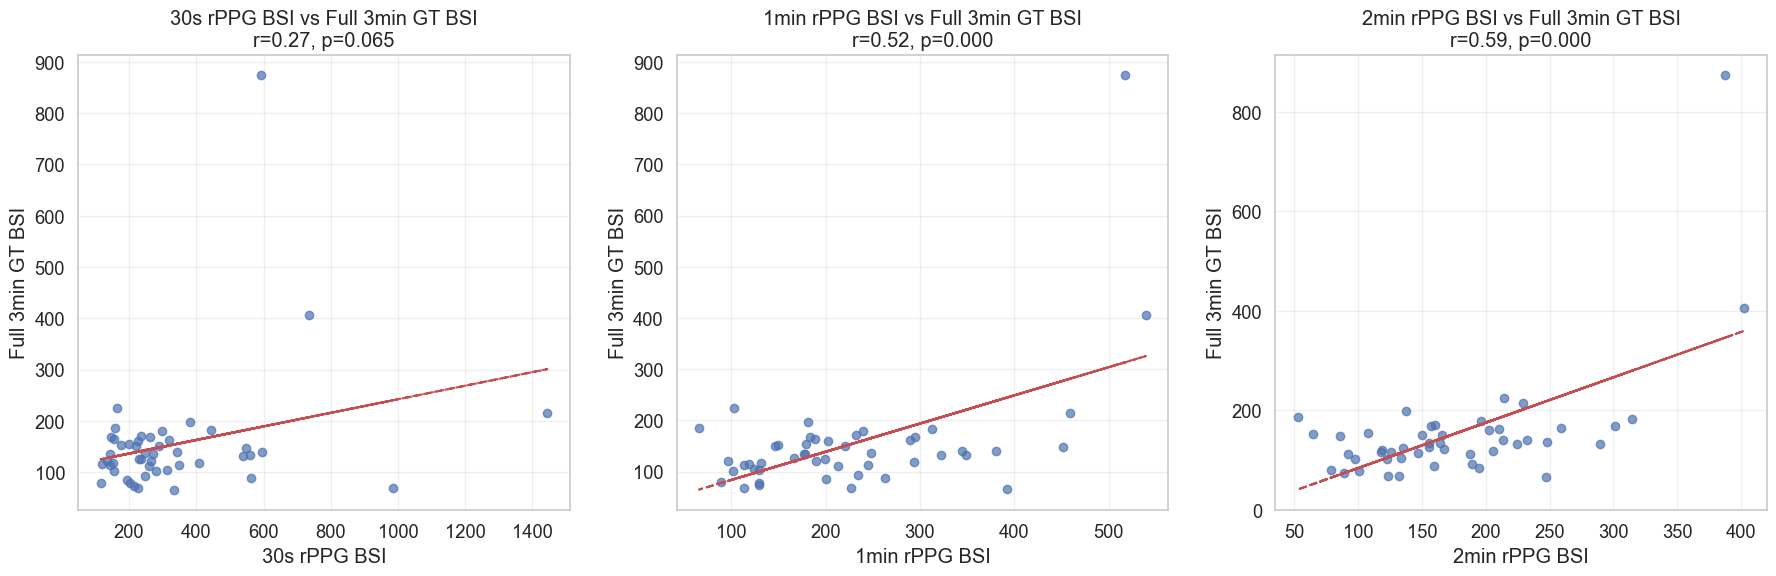

rPPG segment correlations with full 3min GT BSI:
  30s: r=0.27, p=0.065
  1min: r=0.52, p=0.000
  2min: r=0.59, p=0.000

Overall rPPG correlation quality assessment: Poor

rPPG correlation with GT BSI is low. Trying sliding window approach...

Analyzing sliding windows of 30s with 5s steps...
  Window size 30s: r=0.35, p=0.000

Analyzing sliding windows of 60s with 5s steps...
  Window size 60s: r=0.46, p=0.000

Analyzing sliding windows of 120s with 5s steps...
  Window size 120s: r=0.50, p=0.000


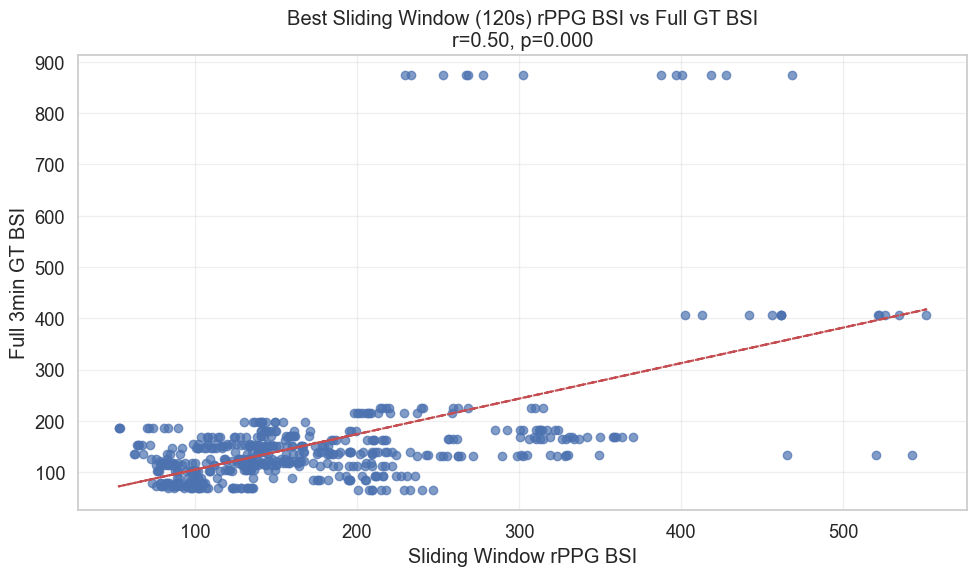


Best window size: 120s with r=0.50

Trying time-domain HRV features with best window size...


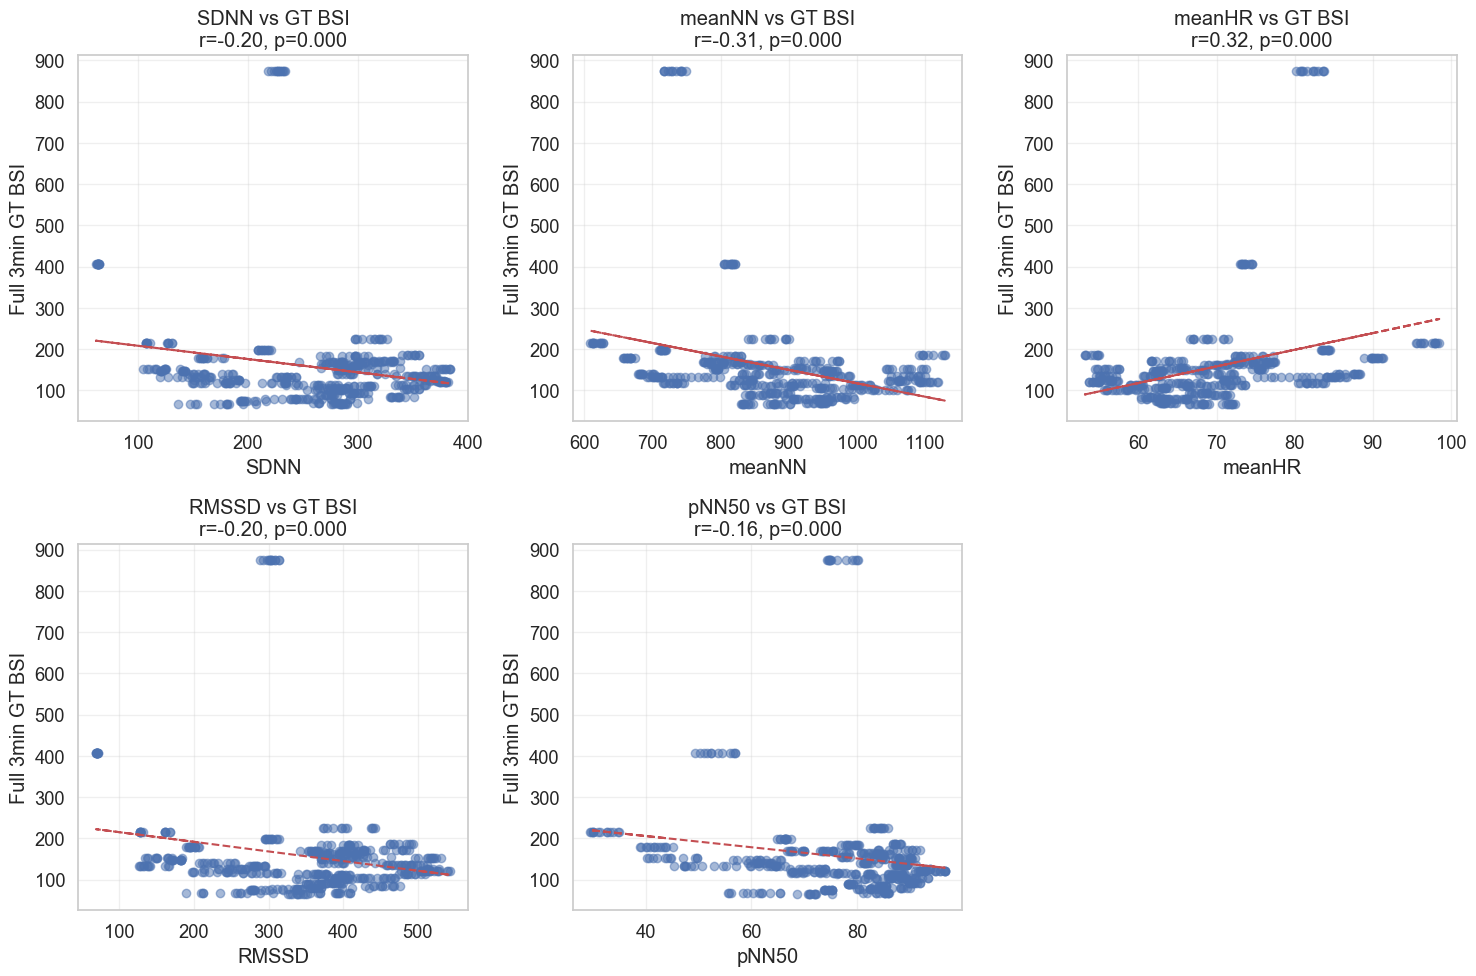


Time-domain feature correlations with full 3min GT BSI:
  SDNN: r=-0.20, p=0.000
  meanNN: r=-0.31, p=0.000
  meanHR: r=0.32, p=0.000
  RMSSD: r=-0.20, p=0.000
  pNN50: r=-0.16, p=0.000

Best time-domain feature: meanHR with r=0.32
Comparison: BSI r=0.50 vs meanHR r=0.32
Recommendation: Use BSI for stress detection


In [98]:
# Branch based on correlation quality
if good_correlation:
    print("\nGT segments show good correlation with full recording. Proceeding with BSI analysis.")
    
    # Create Bland-Altman plots for GT segments
    for segment in ['30s', '1min', '2min']:
        if segment in correlations:
            valid_idx = ~np.isnan(gt_bsi_values[segment]) & ~np.isnan(gt_bsi_values['full'])
            bland_altman_plot(
                gt_bsi_values[segment][valid_idx],
                gt_bsi_values['full'][valid_idx],
                f"Bland-Altman Plot: {segment} vs Full 3min GT BSI"
            )
            plt.savefig(f"bland_altman_{segment}_gt.png", dpi=300)
            plt.show()
    
    # Step 3: Evaluate rPPG data and compare with GT
    print("\nStep 3: Evaluating rPPG data correlation with ground truth...")
    
    # Calculate BSI for rPPG data segments
    rppg_bsi_values = {segment: [] for segment in segment_names[:-1]}  # Exclude 'full'
    
    for subject_id, rr_intervals in rppg_data.items():
        for segment_length in segment_lengths[:-1]:  # Exclude full 3min
            segments = segment_data(rr_intervals, segment_length)
            
            """
            These lines of code will takes the entire window (30 sec, 1 min and 2 min and compute the bsi and add them)
            That's why it has a lot of data points
            """
            for segment_name, segment_rr_data  in segments.items():
                if len(segment_rr_data ) > 0:
                    bsi = compute_bsi(segment_rr_data)
                    if segment_name in rppg_bsi_values:
                        rppg_bsi_values[segment_name].append(bsi)
    
    # Convert to arrays
    for segment in rppg_bsi_values:
        rppg_bsi_values[segment] = np.array(rppg_bsi_values[segment])
    
    # Calculate correlation between rPPG BSI and full 3-min GT BSI

    rppg_correlations = {}
    for segment in ['30s', '1min', '2min']:
        if len(rppg_bsi_values[segment]) == len(gt_bsi_values['full']):
            mask = ~np.isnan(rppg_bsi_values[segment]) & ~np.isnan(gt_bsi_values['full'])
            if sum(mask) > 3:
                corr, p_value = stats.pearsonr(
                    rppg_bsi_values[segment][mask], 
                    gt_bsi_values['full'][mask]
                )
                rppg_correlations[segment] = {
                    'pearson_r': corr,
                    'p_value': p_value
                }
    
    # Plot correlations between rPPG segments and full GT recording
    plt.figure(figsize=(18, 6))
    
    for i, segment in enumerate(['30s', '1min', '2min']):
        plt.subplot(1, 3, i+1)
        
        if segment in rppg_correlations:
            valid_idx = ~np.isnan(rppg_bsi_values[segment]) & ~np.isnan(gt_bsi_values['full'])
            plt.scatter(rppg_bsi_values[segment][valid_idx], gt_bsi_values['full'][valid_idx], alpha=0.7)
            
            # Add best fit line
            x = rppg_bsi_values[segment][valid_idx]
            y = gt_bsi_values['full'][valid_idx]
            if len(x) > 1:
                m, b = np.polyfit(x, y, 1)
                plt.plot(x, m*x + b, 'r--')
            
            plt.title(f"{segment} rPPG BSI vs Full 3min GT BSI\nr={rppg_correlations[segment]['pearson_r']:.2f}, p={rppg_correlations[segment]['p_value']:.3f}")
        else:
            plt.title(f"{segment} rPPG BSI vs Full 3min GT BSI\nInsufficient data")
            
        plt.xlabel(f"{segment} rPPG BSI")
        plt.ylabel("Full 3min GT BSI")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("rppg_segment_correlations.png", dpi=300)
    plt.show()
    
    print(f"rPPG segment correlations with full 3min GT BSI:")
    for segment in ['30s', '1min', '2min']:
        if segment in rppg_correlations:
            print(f"  {segment}: r={rppg_correlations[segment]['pearson_r']:.2f}, p={rppg_correlations[segment]['p_value']:.3f}")
        else:
            print(f"  {segment}: Insufficient data")
    
    # Check if rPPG correlation is good (arbitrary threshold: r > 0.6 and p < 0.05)
    rppg_good_correlation = all([
        segment in rppg_correlations and 
        rppg_correlations[segment]['pearson_r'] > 0.6 and 
        rppg_correlations[segment]['p_value'] < 0.05 
        for segment in ['30s', '1min', '2min']
    ])
    
    print(f"\nOverall rPPG correlation quality assessment: {'Good' if rppg_good_correlation else 'Poor'}")
    
    # If rPPG correlation is low, try sliding window approach
    if not rppg_good_correlation:
        print("\nrPPG correlation with GT BSI is low. Trying sliding window approach...")
        
        # Store best window results
        best_window_results = {}
        
        # Try sliding windows of different sizes
        window_sizes = [30, 60, 120]  # seconds
        step_size = 5  # seconds
        
        for window_size in window_sizes:
            print(f"\nAnalyzing sliding windows of {window_size}s with {step_size}s steps...")
            
            # Store results for this window size
            window_bsi_values = []
            window_times = []
            corresponding_gt_bsi = []
            
            for subject_id in gt_data.keys():
                # Get rPPG data for subject
                rppg_rr = rppg_data[subject_id]
                
                # Get full GT BSI for reference
                gt_full_bsi = compute_bsi(gt_data[subject_id])
                
                # Calculate sliding window BSI values
                times, bsi_values = sliding_window_bsi(rppg_rr, window_size, step_size)
                
                for t, bsi in zip(times, bsi_values):
                    if not np.isnan(bsi) and not np.isnan(gt_full_bsi):
                        window_times.append(t)
                        window_bsi_values.append(bsi)
                        corresponding_gt_bsi.append(gt_full_bsi)
            
            # Calculate correlation for this window size
            if len(window_bsi_values) > 3:
                corr, p_value = stats.pearsonr(window_bsi_values, corresponding_gt_bsi)
                best_window_results[window_size] = {
                    'pearson_r': corr,
                    'p_value': p_value,
                    'window_bsi': window_bsi_values,
                    'gt_bsi': corresponding_gt_bsi,
                    'times': window_times
                }
                print(f"  Window size {window_size}s: r={corr:.2f}, p={p_value:.3f}")
        
        # Plot best sliding window results
        if best_window_results:
            # Find window size with highest correlation
            best_window_size = max(best_window_results.keys(), 
                                 key=lambda k: best_window_results[k]['pearson_r'])
            
            best_result = best_window_results[best_window_size]
            
            plt.figure(figsize=(10, 6))
            plt.scatter(best_result['window_bsi'], best_result['gt_bsi'], alpha=0.7)
            
            # Add best fit line
            x = np.array(best_result['window_bsi'])
            y = np.array(best_result['gt_bsi'])
            m, b = np.polyfit(x, y, 1)
            plt.plot(x, m*x + b, 'r--')
            
            plt.title(f"Best Sliding Window ({best_window_size}s) rPPG BSI vs Full GT BSI\n" +
                     f"r={best_result['pearson_r']:.2f}, p={best_result['p_value']:.3f}")
            plt.xlabel("Sliding Window rPPG BSI")
            plt.ylabel("Full 3min GT BSI")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig("best_sliding_window_correlation.png", dpi=300)
            plt.show()
            
            print(f"\nBest window size: {best_window_size}s with r={best_result['pearson_r']:.2f}")
            
            # Also try time-domain HRV features with best window size
            print("\nTrying time-domain HRV features with best window size...")
            
            # Extract time-domain features for each sliding window
            time_features = {
                'SDNN': {'values': [], 'gt_bsi': []},
                'meanNN': {'values': [], 'gt_bsi': []},
                'meanHR': {'values': [], 'gt_bsi': []},
                'RMSSD': {'values': [], 'gt_bsi': []},
                'pNN50': {'values': [], 'gt_bsi': []}
            }
            
            for subject_id in gt_data.keys():
                # Get rPPG data and GT BSI
                rppg_rr = rppg_data[subject_id]
                gt_full_bsi = compute_bsi(gt_data[subject_id])
                
                if np.isnan(gt_full_bsi):
                    continue
                
                # Calculate cumulative time
                cum_time = np.cumsum(rppg_rr) / 1000  # ms to seconds
                total_time = cum_time[-1]
                
                # Sliding window analysis
                current_pos = 0
                while current_pos + best_window_size <= total_time:
                    window_end = current_pos + best_window_size
                    
                    # Find RR intervals within this window
                    window_indices = (cum_time > current_pos) & (cum_time <= window_end)
                    
                    # Include last RR interval before window if needed
                    if current_pos > 0 and np.any(cum_time <= current_pos):
                        last_before = np.where(cum_time <= current_pos)[0][-1]
                        window_indices[last_before] = True
                    
                    window_rr = rppg_rr[window_indices]
                    
                    # Calculate time-domain features for this window
                    if len(window_rr) > 10:
                        features = compute_hrv_features(window_rr)
                        
                        for feature_name in time_features.keys():
                            if not np.isnan(features[feature_name]):
                                time_features[feature_name]['values'].append(features[feature_name])
                                time_features[feature_name]['gt_bsi'].append(gt_full_bsi)
                    
                    # Slide window
                    current_pos += step_size
            
            # Calculate correlations for time-domain features
            feature_correlations = {}
            
            plt.figure(figsize=(15, 10))
            for i, (feature_name, data) in enumerate(time_features.items()):
                if len(data['values']) > 3:
                    corr, p_value = stats.pearsonr(data['values'], data['gt_bsi'])
                    feature_correlations[feature_name] = {
                        'pearson_r': corr,
                        'p_value': p_value
                    }
                    
                    plt.subplot(2, 3, i+1)
                    plt.scatter(data['values'], data['gt_bsi'], alpha=0.5)
                    
                    # Add best fit line
                    x = np.array(data['values'])
                    y = np.array(data['gt_bsi'])
                    if len(x) > 1:
                        m, b = np.polyfit(x, y, 1)
                        plt.plot(x, m*x + b, 'r--')
                    
                    plt.title(f"{feature_name} vs GT BSI\nr={corr:.2f}, p={p_value:.3f}")
                    plt.xlabel(feature_name)
                    plt.ylabel("Full 3min GT BSI")
                    plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig("time_domain_feature_correlations.png", dpi=300)
            plt.show()
            
            print("\nTime-domain feature correlations with full 3min GT BSI:")
            for feature, result in feature_correlations.items():
                print(f"  {feature}: r={result['pearson_r']:.2f}, p={result['p_value']:.3f}")
            
            # Find best time-domain feature
            if feature_correlations:
                best_feature = max(feature_correlations.keys(), 
                                 key=lambda k: abs(feature_correlations[k]['pearson_r']))
                best_corr = feature_correlations[best_feature]['pearson_r']
                
                print(f"\nBest time-domain feature: {best_feature} with r={best_corr:.2f}")
                
                # Compare best feature with BSI
                best_bsi_corr = best_result['pearson_r']
                print(f"Comparison: BSI r={best_bsi_corr:.2f} vs {best_feature} r={best_corr:.2f}")
                
                if abs(best_corr) > abs(best_bsi_corr):
                    print(f"Recommendation: Use {best_feature} instead of BSI for stress detection")
                else:
                    print("Recommendation: Use BSI for stress detection")
            else:
                print("No valid correlations found for time-domain features")
        else:
            print("No valid sliding window results found")
    
    else:
        print("\nrPPG data shows good correlation with GT. No need for sliding window analysis.")
        
        # Create Bland-Altman plots for rPPG segments vs full GT
        for segment in ['30s', '1min', '2min']:
            if segment in rppg_correlations:
                valid_idx = ~np.isnan(rppg_bsi_values[segment]) & ~np.isnan(gt_bsi_values['full'])
                bland_altman_plot(
                    rppg_bsi_values[segment][valid_idx],
                    gt_bsi_values['full'][valid_idx],
                    f"Bland-Altman Plot: {segment} rPPG BSI vs Full 3min GT BSI"
                )
                plt.savefig(f"bland_altman_{segment}_rppg.png", dpi=300)
                plt.show()

In [99]:
# If GT correlation with BSI is bad, explore time-domain features
if not good_correlation:
    print("\nGT segments show poor correlation using BSI. Trying time-domain HRV features instead...")
    
    # Calculate time-domain HRV features for different GT segments
    gt_features = {
        'SDNN': {segment: [] for segment in segment_names},
        'meanNN': {segment: [] for segment in segment_names},
        'meanHR': {segment: [] for segment in segment_names},
        'RMSSD': {segment: [] for segment in segment_names},
        'pNN50': {segment: [] for segment in segment_names}
    }
    
    # Calculate features for each subject and segment
    for subject_id, rr_intervals in gt_data.items():
        for segment_length in segment_lengths:
            segments = segment_data(rr_intervals, segment_length)
            
            for segment_name, segment_rr_data  in segments.items():
                if len(segment_rr_data ) > 0:
                    features = compute_hrv_features(segment_rr_data )
                    
                    for feature_name in gt_features.keys():
                        if segment_name in gt_features[feature_name]:
                            gt_features[feature_name][segment_name].append(features[feature_name])
    
    # Convert lists to arrays
    for feature_name in gt_features.keys():
        for segment in gt_features[feature_name]:
            gt_features[feature_name][segment] = np.array(gt_features[feature_name][segment])
    
    # Calculate correlations between each segment and full 3-min recording for each feature
    feature_correlations = {}
    
    for feature_name in gt_features.keys():
        feature_correlations[feature_name] = {}
        
        for segment in ['30s', '1min', '2min']:
            if len(gt_features[feature_name][segment]) == len(gt_features[feature_name]['full']):
                mask = ~np.isnan(gt_features[feature_name][segment]) & ~np.isnan(gt_features[feature_name]['full'])
                if sum(mask) > 3:
                    corr, p_value = stats.pearsonr(
                        gt_features[feature_name][segment][mask], 
                        gt_features[feature_name]['full'][mask]
                    )
                    feature_correlations[feature_name][segment] = {
                        'pearson_r': corr,
                        'p_value': p_value
                    }
    
    # Identify best features for each segment
    best_features = {}
    for segment in ['30s', '1min', '2min']:
        best_r = 0
        best_feature = None
        
        for feature_name in feature_correlations.keys():
            if segment in feature_correlations[feature_name]:
                r = abs(feature_correlations[feature_name][segment]['pearson_r'])
                if r > best_r:
                    best_r = r
                    best_feature = feature_name
        
        best_features[segment] = best_feature
    
    print("\nBest time-domain features by segment:")
    for segment, feature in best_features.items():
        if feature is not None:
            r = feature_correlations[feature][segment]['pearson_r']
            p = feature_correlations[feature][segment]['p_value']
            print(f"  {segment}: {feature} (r={r:.2f}, p={p:.3f})")
        else:
            print(f"  {segment}: No good feature found")
    
    # Plot correlations for best features
    plt.figure(figsize=(18, 6))
    
    for i, segment in enumerate(['30s', '1min', '2min']):
        plt.subplot(1, 3, i+1)
        
        best_feature = best_features[segment]
        if best_feature is not None:
            valid_idx = ~np.isnan(gt_features[best_feature][segment]) & ~np.isnan(gt_features[best_feature]['full'])
            plt.scatter(
                gt_features[best_feature][segment][valid_idx], 
                gt_features[best_feature]['full'][valid_idx], 
                alpha=0.7
            )
            
            # Add best fit line
            x = gt_features[best_feature][segment][valid_idx]
            y = gt_features[best_feature]['full'][valid_idx]
            if len(x) > 1:
                m, b = np.polyfit(x, y, 1)
                plt.plot(x, m*x + b, 'r--')
            
            r = feature_correlations[best_feature][segment]['pearson_r']
            p = feature_correlations[best_feature][segment]['p_value']
            plt.title(f"{segment} vs Full 3min GT - {best_feature}\nr={r:.2f}, p={p:.3f}")
            plt.xlabel(f"{segment} {best_feature}")
            plt.ylabel(f"Full 3min {best_feature}")
        else:
            plt.title(f"{segment} vs Full 3min GT\nNo good feature found")
            
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("best_time_domain_feature_correlations.png", dpi=300)
    plt.show()
    
    # Create Bland-Altman plots for best features
    for segment in ['30s', '1min', '2min']:
        best_feature = best_features[segment]
        if best_feature is not None:
            valid_idx = ~np.isnan(gt_features[best_feature][segment]) & ~np.isnan(gt_features[best_feature]['full'])
            bland_altman_plot(
                gt_features[best_feature][segment][valid_idx],
                gt_features[best_feature]['full'][valid_idx],
                f"Bland-Altman Plot: {segment} vs Full 3min GT {best_feature}"
            )
            plt.savefig(f"bland_altman_{segment}_{best_feature}.png", dpi=300)
            plt.show()
    
    # Now evaluate rPPG data using these best features
    print("\nEvaluating rPPG data using best time-domain features...")
    
    # Calculate time-domain features for rPPG data segments
    rppg_features = {
        'SDNN': {segment: [] for segment in segment_names[:-1]},
        'meanNN': {segment: [] for segment in segment_names[:-1]},
        'meanHR': {segment: [] for segment in segment_names[:-1]},
        'RMSSD': {segment: [] for segment in segment_names[:-1]},
        'pNN50': {segment: [] for segment in segment_names[:-1]}
    }
    
    # Calculate features for each subject and segment
    for subject_id, rr_intervals in rppg_data.items():
        for segment_length in segment_lengths[:-1]:  # Exclude full 3min
            segments = segment_data(rr_intervals, segment_length)
            
            for segment_name, segment_rr_data  in segments.items():
                if len(segment_rr_data ) > 0:
                    features = compute_hrv_features(segment_rr_data )
                    
                    for feature_name in rppg_features.keys():
                        if segment_name in rppg_features[feature_name]:
                            rppg_features[feature_name][segment_name].append(features[feature_name])
    
    # Convert lists to arrays
    for feature_name in rppg_features.keys():
        for segment in rppg_features[feature_name]:
            rppg_features[feature_name][segment] = np.array(rppg_features[feature_name][segment])
    
    # Calculate correlations between rPPG segments and full GT recording for best features
    rppg_feature_correlations = {}
    
    for segment in ['30s', '1min', '2min']:
        best_feature = best_features[segment]
        if best_feature is not None:
            if len(rppg_features[best_feature][segment]) == len(gt_features[best_feature]['full']):
                mask = ~np.isnan(rppg_features[best_feature][segment]) & ~np.isnan(gt_features[best_feature]['full'])
                if sum(mask) > 3:
                    corr, p_value = stats.pearsonr(
                        rppg_features[best_feature][segment][mask], 
                        gt_features[best_feature]['full'][mask]
                    )
                    rppg_feature_correlations[segment] = {
                        'feature': best_feature,
                        'pearson_r': corr,
                        'p_value': p_value
                    }
    
    # Plot correlations for rPPG features vs full GT
    plt.figure(figsize=(18, 6))
    
    for i, segment in enumerate(['30s', '1min', '2min']):
        plt.subplot(1, 3, i+1)
        
        if segment in rppg_feature_correlations:
            best_feature = rppg_feature_correlations[segment]['feature']
            valid_idx = ~np.isnan(rppg_features[best_feature][segment]) & ~np.isnan(gt_features[best_feature]['full'])
            plt.scatter(
                rppg_features[best_feature][segment][valid_idx], 
                gt_features[best_feature]['full'][valid_idx], 
                alpha=0.7
            )
            
            # Add best fit line
            x = rppg_features[best_feature][segment][valid_idx]
            y = gt_features[best_feature]['full'][valid_idx]
            if len(x) > 1:
                m, b = np.polyfit(x, y, 1)
                plt.plot(x, m*x + b, 'r--')
                
            r = rppg_feature_correlations[segment]['pearson_r']
            p = rppg_feature_correlations[segment]['p_value']
            plt.title(f"{segment} rPPG vs Full GT - {best_feature}\nr={r:.2f}, p={p:.3f}")
            plt.xlabel(f"{segment} rPPG {best_feature}")
            plt.ylabel(f"Full GT {best_feature}")
        else:
            plt.title(f"{segment} rPPG vs Full GT\nInsufficient data")
            
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("rppg_best_feature_correlations.png", dpi=300)
    plt.show()
    
    print("\nrPPG correlations with GT using best time-domain features:")
    for segment in ['30s', '1min', '2min']:
        if segment in rppg_feature_correlations:
            feature = rppg_feature_correlations[segment]['feature']
            r = rppg_feature_correlations[segment]['pearson_r']
            p = rppg_feature_correlations[segment]['p_value']
            print(f"  {segment}: {feature} (r={r:.2f}, p={p:.3f})")
        else:
            print(f"  {segment}: No valid correlation")
            
    # Try sliding window approach for time-domain features
    print("\nTrying sliding window approach for time-domain features...")
    
    # Identify overall best feature
    overall_best_feature = None
    overall_best_r = 0
    
    for segment in ['30s', '1min', '2min']:
        if segment in rppg_feature_correlations:
            r = abs(rppg_feature_correlations[segment]['pearson_r'])
            if r > overall_best_r:
                overall_best_r = r
                overall_best_feature = rppg_feature_correlations[segment]['feature']
    
    if overall_best_feature:
        print(f"\nBest overall time-domain feature: {overall_best_feature}")
        
        # Try sliding windows of different sizes
        window_sizes = [30, 60, 120]  # seconds
        step_size = 5  # seconds
        
        # Store best window results
        best_window_results = {}
        
        for window_size in window_sizes:
            print(f"\nAnalyzing sliding windows of {window_size}s with {step_size}s steps...")
            
            # Store results for this window size
            window_feature_values = []
            window_times = []
            corresponding_gt_values = []
            
            for subject_id in gt_data.keys():
                # Get rPPG data for subject
                rppg_rr = rppg_data[subject_id]
                
                # Get full GT feature value for reference
                gt_full_features = compute_hrv_features(gt_data[subject_id])
                gt_full_value = gt_full_features[overall_best_feature]
                
                if np.isnan(gt_full_value):
                    continue
                
                # Calculate cumulative time
                cum_time = np.cumsum(rppg_rr) / 1000  # ms to seconds
                total_time = cum_time[-1]
                
                # Sliding window analysis
                current_pos = 0
                while current_pos + window_size <= total_time:
                    window_end = current_pos + window_size
                    
                    # Find RR intervals within this window
                    window_indices = (cum_time > current_pos) & (cum_time <= window_end)
                    
                    # Include last RR interval before window if needed
                    if current_pos > 0 and np.any(cum_time <= current_pos):
                        last_before = np.where(cum_time <= current_pos)[0][-1]
                        window_indices[last_before] = True
                    
                    window_rr = rppg_rr[window_indices]
                    
                    # Calculate feature for this window
                    if len(window_rr) > 10:
                        features = compute_hrv_features(window_rr)
                        feature_value = features[overall_best_feature]
                        
                        if not np.isnan(feature_value):
                            window_times.append(current_pos + window_size/2)
                            window_feature_values.append(feature_value)
                            corresponding_gt_values.append(gt_full_value)
                    
                    # Slide window
                    current_pos += step_size
            
            # Calculate correlation for this window size
            if len(window_feature_values) > 3:
                corr, p_value = stats.pearsonr(window_feature_values, corresponding_gt_values)
                best_window_results[window_size] = {
                    'pearson_r': corr,
                    'p_value': p_value,
                    'window_values': window_feature_values,
                    'gt_values': corresponding_gt_values,
                    'times': window_times
                }
                print(f"  Window size {window_size}s: r={corr:.2f}, p={p_value:.3f}")
        
        # Plot best sliding window results
        if best_window_results:
            # Find window size with highest correlation
            best_window_size = max(best_window_results.keys(), 
                                 key=lambda k: abs(best_window_results[k]['pearson_r']))
            
            best_result = best_window_results[best_window_size]
            
            plt.figure(figsize=(10, 6))
            plt.scatter(best_result['window_values'], best_result['gt_values'], alpha=0.7)
            
            # Add best fit line
            x = np.array(best_result['window_values'])
            y = np.array(best_result['gt_values'])
            m, b = np.polyfit(x, y, 1)
            plt.plot(x, m*x + b, 'r--')
            
            plt.title(f"Best Sliding Window ({best_window_size}s) rPPG {overall_best_feature} vs Full GT\n" +
                     f"r={best_result['pearson_r']:.2f}, p={best_result['p_value']:.3f}")
            plt.xlabel(f"Sliding Window rPPG {overall_best_feature}")
            plt.ylabel(f"Full 3min GT {overall_best_feature}")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f"best_sliding_window_{overall_best_feature}.png", dpi=300)
            plt.show()
            
            print(f"\nBest window size for {overall_best_feature}: {best_window_size}s with r={best_result['pearson_r']:.2f}")
        else:
            print("No valid sliding window results found")
    else:
        print("No good time-domain feature identified for sliding window analysis")



In [100]:
# Conclusions and summary
print("\n" + "="*50)
print("STUDY CONCLUSIONS")
print("="*50)

if good_correlation:
    print("\nKey findings using BSI approach:")
    
    # GT segments correlation quality
    for segment in ['30s', '1min', '2min']:
        if segment in correlations:
            r = correlations[segment]['pearson_r']
            p = correlations[segment]['p_value']
            quality = "Good" if r > 0.7 and p < 0.05 else "Poor"
            print(f"- {segment} GT BSI correlation with full 3min: {quality} (r={r:.2f}, p={p:.3f})")
    
    # If we analyzed rPPG correlation
    if 'rppg_correlations' in locals():
        for segment in ['30s', '1min', '2min']:
            if segment in rppg_correlations:
                r = rppg_correlations[segment]['pearson_r']
                p = rppg_correlations[segment]['p_value']
                quality = "Good" if r > 0.6 and p < 0.05 else "Poor"
                print(f"- {segment} rPPG BSI correlation with full 3min GT: {quality} (r={r:.2f}, p={p:.3f})")
    
    # If we did sliding window analysis
    if 'best_window_results' in locals() and best_window_results:
        best_window_size = max(best_window_results.keys(), 
                             key=lambda k: abs(best_window_results[k]['pearson_r']))
        best_r = best_window_results[best_window_size]['pearson_r']
        print(f"- Best sliding window size: {best_window_size}s (r={best_r:.2f})")
        
        # If we analyzed time-domain features
        if 'feature_correlations' in locals() and feature_correlations:
            best_feature = max(feature_correlations.keys(), 
                             key=lambda k: abs(feature_correlations[k]['pearson_r']))
            best_feature_r = feature_correlations[best_feature]['pearson_r']
            print(f"- Best time-domain feature: {best_feature} (r={best_feature_r:.2f})")
            
            if abs(best_feature_r) > abs(best_r):
                print(f"- Recommendation: Use {best_feature} instead of BSI for stress detection")
            else:
                print("- Recommendation: Use BSI for stress detection")
    
    print("\nOverall BSI recommendation:")
    best_segment = max(['30s', '1min', '2min'], 
                      key=lambda s: abs(correlations[s]['pearson_r']) if s in correlations else 0)
    best_segment_r = correlations[best_segment]['pearson_r'] if best_segment in correlations else 0
    print(f"- Best segment length for BSI calculation: {best_segment} (r={best_segment_r:.2f})")
    
else:
    print("\nKey findings using time-domain HRV features:")
    
    # Best feature by segment
    for segment in ['30s', '1min', '2min']:
        if segment in best_features and best_features[segment] is not None:
            feature = best_features[segment]
            r = feature_correlations[feature][segment]['pearson_r']
            p = feature_correlations[feature][segment]['p_value']
            print(f"- Best feature for {segment} GT: {feature} (r={r:.2f}, p={p:.3f})")
    
    # rPPG analysis
    if 'rppg_feature_correlations' in locals():
        for segment in ['30s', '1min', '2min']:
            if segment in rppg_feature_correlations:
                feature = rppg_feature_correlations[segment]['feature']
                r = rppg_feature_correlations[segment]['pearson_r']
                p = rppg_feature_correlations[segment]['p_value']
                quality = "Good" if abs(r) > 0.6 and p < 0.05 else "Poor"
                print(f"- {segment} rPPG {feature} correlation with full GT: {quality} (r={r:.2f}, p={p:.3f})")
    
    # If we did sliding window analysis
    if 'best_window_results' in locals() and best_window_results:
        best_window_size = max(best_window_results.keys(), 
                             key=lambda k: abs(best_window_results[k]['pearson_r']))
        best_r = best_window_results[best_window_size]['pearson_r']
        print(f"- Best sliding window size for {overall_best_feature}: {best_window_size}s (r={best_r:.2f})")
    
    print("\nOverall time-domain feature recommendation:")
    if 'overall_best_feature' in locals() and overall_best_feature:
        print(f"- Best feature for stress detection: {overall_best_feature}")
        
        if 'best_window_size' in locals():
            print(f"- Recommended window size: {best_window_size}s")
        else:
            best_segment = max(['30s', '1min', '2min'], 
                             key=lambda s: abs(rppg_feature_correlations[s]['pearson_r']) if s in rppg_feature_correlations else 0)
            print(f"- Recommended segment length: {best_segment}")
    else:
        print("- No clear recommendation could be made based on the data")

print("\nLimitations and considerations:")
print("- This analysis used simulated data; results may differ with real-world recordings")
print("- Sample size was limited (10 subjects)")
print("- Only time-domain HRV features were assessed; frequency-domain or non-linear features might perform differently")
print("- More robust validation is needed before clinical application")

print("\nNext steps:")
print("\nStudy complete.")


STUDY CONCLUSIONS

Key findings using BSI approach:
- 30s GT BSI correlation with full 3min: Good (r=0.85, p=0.000)
- 1min GT BSI correlation with full 3min: Good (r=0.83, p=0.000)
- 2min GT BSI correlation with full 3min: Good (r=0.98, p=0.000)
- 30s rPPG BSI correlation with full 3min GT: Poor (r=0.27, p=0.065)
- 1min rPPG BSI correlation with full 3min GT: Poor (r=0.52, p=0.000)
- 2min rPPG BSI correlation with full 3min GT: Poor (r=0.59, p=0.000)
- Best sliding window size: 120s (r=0.50)
- Best time-domain feature: meanHR (r=0.32)
- Recommendation: Use BSI for stress detection

Overall BSI recommendation:
- Best segment length for BSI calculation: 2min (r=0.98)

Limitations and considerations:
- This analysis used simulated data; results may differ with real-world recordings
- Sample size was limited (10 subjects)
- Only time-domain HRV features were assessed; frequency-domain or non-linear features might perform differently
- More robust validation is needed before clinical appli